In [1]:
import SIRD_Model

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [2]:
pathc = "../Data/Italian Data/"
# modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "National Data.csv"

dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

In [72]:
from sklearn import linear_model

#note paramArg is in the format of [q, beta, gamma, nu] [q, b1, b2, b3, b0, gamma, nu]
def errorSIRD(paramArg, pop, I, R, D, lamda, w): #the custom error function for SIRD    
    
    q = paramArg[0]
    b = paramArg[0:4]
    b[0] = paramArg[4] #b=[b0, b1, b2, b3]
    params = paramArg[-3:] #beta0, gamma, nu
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    #use b0 in the place of beta, and multiply first column by 1/(1+(I*b1+D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D
    
    y, A = SIRD_Model.getSIRDMatrices(S, I, R, D)
    
    #transform location where beta is needed and multiply by 1/(1+(I*b1+D*b2)^b3)
    #in this case use new daily infections for I and new deaths for d
    #newI = np.diff(I+R+D)
    #newD = np.diff(D)
    #A[:,0,0] = A[:,0,0] / (1 + (newI*b[1] + newD*b[2])**b[3])
    #A[:,1,0] = A[:,1,0] / (1 + (newI*b[1] + newD*b[2])**b[3])
    
    #in this case just use I and D plain
    A[:,0,0] = A[:,0,0] / (1 + (I[:-1]*b[1] + D[:-1]*b[2])**b[3])
    A[:,1,0] = A[:,1,0] / (1 + (I[:-1]*b[1] + D[:-1]*b[2])**b[3])
    
    totalError = 0
    #see paper for optimization function
    T = len(A)
    for t in range(T):
        totalError = totalError + (w**(T - t))*(np.linalg.norm((A[t] @ params) - y[t].transpose(), ord=2)**2)
    
    #return (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    totalError = (1.0/T)*totalError #divide by timeframe
    totalError = totalError + lamda*np.linalg.norm(params, ord=1) #regularization error
    return totalError

def getLinVarsSIRD(paramArg, pop, I, R, D, lamda, w): #calculate the linear vars for the SIRD model, b0, gamma, nu  
    
    q = paramArg[0]
    b1 = paramArg[1]
    b2 = paramArg[2]
    b3 = paramArg[3]
    
    #b0, gamma, nu should be solved for
    
    #note: beta = b0 / (1 + (I*b1 + D*b2)^b3)
    
    S = q*pop - I - R - D #q*Pop = S + I + R + D
    
    nextIterMatrix, sirdMatrix = SIRD_Model.getSIRDMatricesFlat(S,I,R,D)
    #construct y and A, see paper for solving the lasso optimization
    T = int(len(nextIterMatrix)/4)
    y = np.zeros((T*4, 1))
    A = np.zeros((T*4, 3))
    for t in range(T):
        y[4*t+0] = nextIterMatrix[4*t+0] * np.sqrt(w**(T - t))
        y[4*t+1] = nextIterMatrix[4*t+1] * np.sqrt(w**(T - t))
        y[4*t+2] = nextIterMatrix[4*t+2] * np.sqrt(w**(T - t))
        y[4*t+3] = nextIterMatrix[4*t+3] * np.sqrt(w**(T - t))

        #transform location where beta is needed and multiply by 1/(1+(I*b1+D*b2)^b3)
        #in this case use new daily infections for I and new deaths for d
        #newI = np.diff(I+R+D)
        #newD = np.diff(D)
        #sirdMatrix[4*t+0,0] = sirdMatrix[4*t+0,0] / (1 + (newI[t]*b1 + newD[t]*b2)**b3)
        #sirdMatrix[4*t+1,0] = sirdMatrix[4*t+1,0] / (1 + (newI[t]*b1 + newD[t]*b2)**b3)
        
        #in this case just use I and D plain
        sirdMatrix[4*t+0,0] = sirdMatrix[4*t+0,0] / (1 + (I[t]*b1 + D[t]*b2)**b3)
        sirdMatrix[4*t+1,0] = sirdMatrix[4*t+1,0] / (1 + (I[t]*b1 + D[t]*b2)**b3)
        
        A[4*t+0] = sirdMatrix[4*t+0] * np.sqrt(w**(T - t))
        A[4*t+1] = sirdMatrix[4*t+1] * np.sqrt(w**(T - t))
        A[4*t+2] = sirdMatrix[4*t+2] * np.sqrt(w**(T - t))
        A[4*t+3] = sirdMatrix[4*t+3] * np.sqrt(w**(T - t))
            
            
    model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True)
    model.fit(A,y)
    params = model.coef_
    
    #totalError = (1.0/T) * np.linalg.norm((A @ params) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(params, ord=1)
    return list(params)

def gridNonLinVars(constraints, varResols, pop, I, R, D, lamda, w): #solve for non linear vars, q, b1, b2, b3
    
    #varSteps[:] = constraints[:][0] + (constraints[:][1] - constraints[:][0])/varResols[:]
    varSteps = []
    for i in range(len(constraints)):
        varSteps.append(constraints[i][0] + (constraints[i][1] - constraints[i][0])/varResols[i]) #min + (max - min)/resol
        if(varSteps[-1] == 0):
            varSteps[-1] = 1 #avoids infinite loop and zero step movement
            
    #note beta = b0/(1 + (b1*I + b2*D)^b3)
    #assume starting vals as best starting value
    #minVars = constraints[:][0]
    minVars = []
    for i in range(len(constraints)): #fill minVars with the minimum starting value
        minVars.append((constraints[i][0]))
    
    paramArg = getLinVarsSIRD(minVars, pop, I, R, D, lamda, w)
    minCost = errorSIRD(minVars + paramArg, pop, I, R, D, lamda, w) #the custom error function for SIRD
    
    currVars = minVars.copy() #deep copy
    currCost = minCost
    varIndex = 0 #which var to iterate
    #while the var isn't above it's max
    continueLoop = True
    #this could be achieved by using many for loops, but this is a more generalized appraoch
    while(continueLoop):
    
        paramArg = getLinVarsSIRD(currVars, pop, I, R, D, lamda, w)
        currCost = errorSIRD(currVars + paramArg, pop, I, R, D, lamda, w)
        if(currCost < minCost):
            minCost = currCost
            minVars = currVars.copy()
    
        #print("at: ", currVars, currCost)

        currVars[varIndex] = currVars[varIndex] + varSteps[varIndex]
        while(currVars[varIndex] > constraints[varIndex][1]): #move varIndex anditerate appropriately
                currVars[varIndex] = constraints[varIndex][0] #reset to minimum
                varIndex = varIndex + 1 #move to iterating the next variable

                if(varIndex == len(currVars)): #out of range, end Loop
                    continueLoop = False
                    break
                currVars[varIndex] = currVars[varIndex] + varSteps[varIndex] #iterate var        
        varIndex = 0 
        
    return minVars, paramArg #return vars and linVars

def solveAllVars(nonLinConstraints, nonLinResol, pop, I, R, D, lamda, w):
    nonLinVars, linVars = gridNonLinVars(nonLinConstraints, nonLinResol, pop, I, R, D, lamda, w)

    print("Solution: ")
    print("q:  ", nonLinVars[0])
    print("b0: ", linVars[0])
    print("b1: ", nonLinVars[1])
    print("b2: ", nonLinVars[2])
    print("b3: ", nonLinVars[3])
    print("g:  ", linVars[1])
    print("nu: ", linVars[2])
    print("cost: ", errorSIRD(nonLinVars + linVars, pop, I, R, D, lamda, w))
    print() #spacer
        
    finalVars = []
    finalVars.append(nonLinVars[0]) #q
    finalVars.append(linVars[0]) #b0
    finalVars.append(nonLinVars[1]) #b1
    finalVars.append(nonLinVars[2]) #b2
    finalVars.append(nonLinVars[3]) #b3
    finalVars.append(linVars[1]) #gamma
    finalVars.append(linVars[2]) #nu
    return finalVars
    

Solution: 
q:   0.09
b0:  0.22490934786155833
b1:  8.000000000000001e-07
b2:  0
b3:  1
g:   0.030315954028325362
nu:  0.0
cost:  3000565368.596427



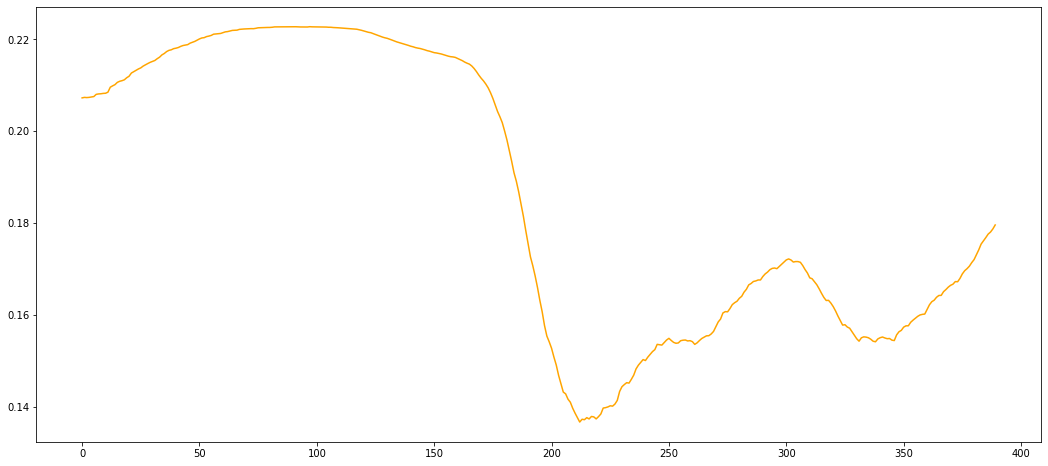

In [80]:
pop = 60000000
skipDays = 60
numDays = len(infectRaw) #max days
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays]
dead = deadRaw[skipDays:numDays]

boundQ = (.09,.09) #q should be between 0 and 1
#Beta = b0/(1+(I*b1 + D*b2)^b3)
boundB1 = (0,.00001)
boundB2 = (0,.00000)
boundB3 = (1,2)

lamda = 10 #regularization weight
wVal = 1 #weight decay, when w is 1 there is no decay (all days weighted equal)

constraints = [boundQ, boundB1, boundB2, boundB3]
varResol = [1,100,1,5] #resolution for each variable

constArgt = (pop, infect, recov, dead, lamda, wVal)


finalVars = solveAllVars(constraints, varResol, *constArg)

#beta = b0 / 1 + (I*b1+D*b2)**b3
betaVars = finalVars[1:5]
beta = betaVars[0] / (1 + (infect*betaVars[1] + dead*betaVars[2])**betaVars[3])

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(beta, color='orange', label='Transmission Rate')

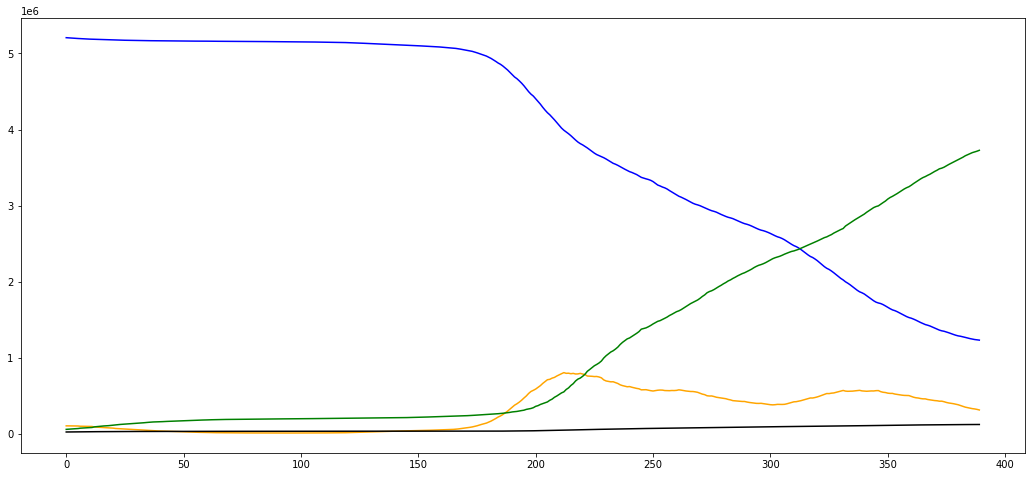

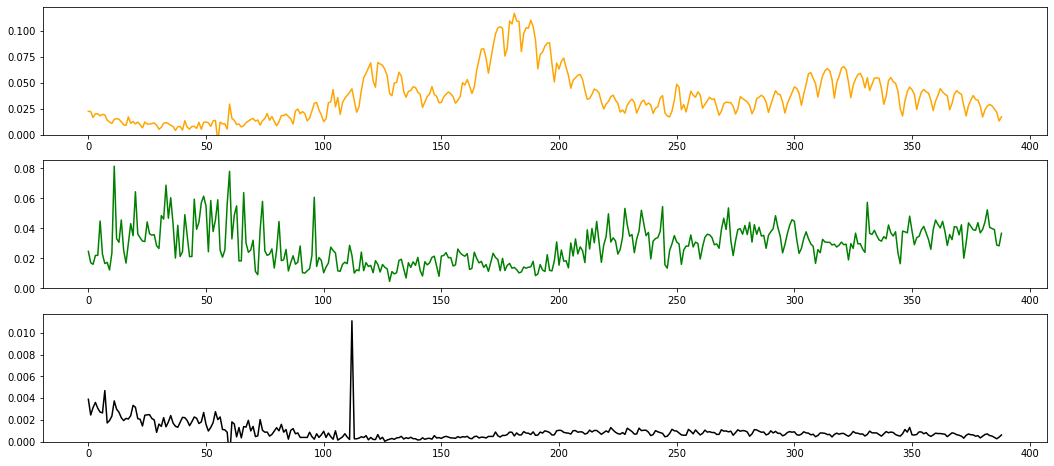

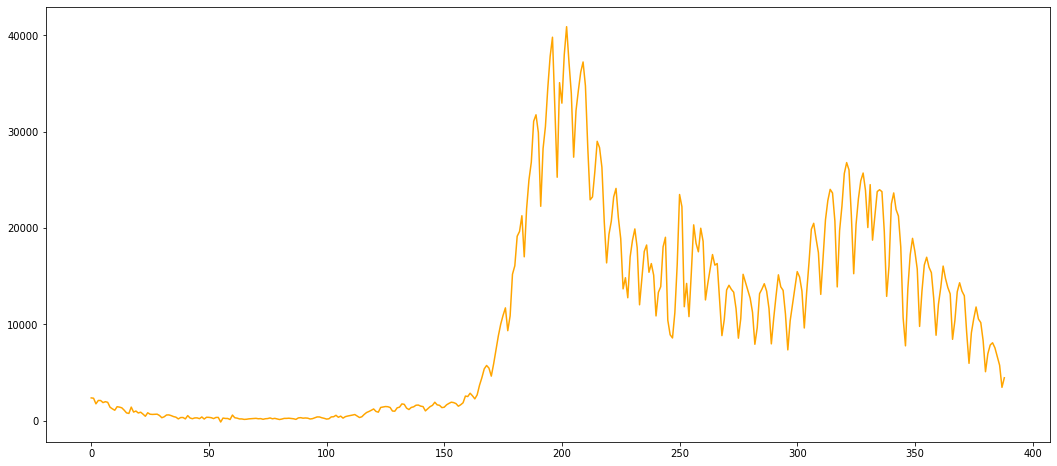

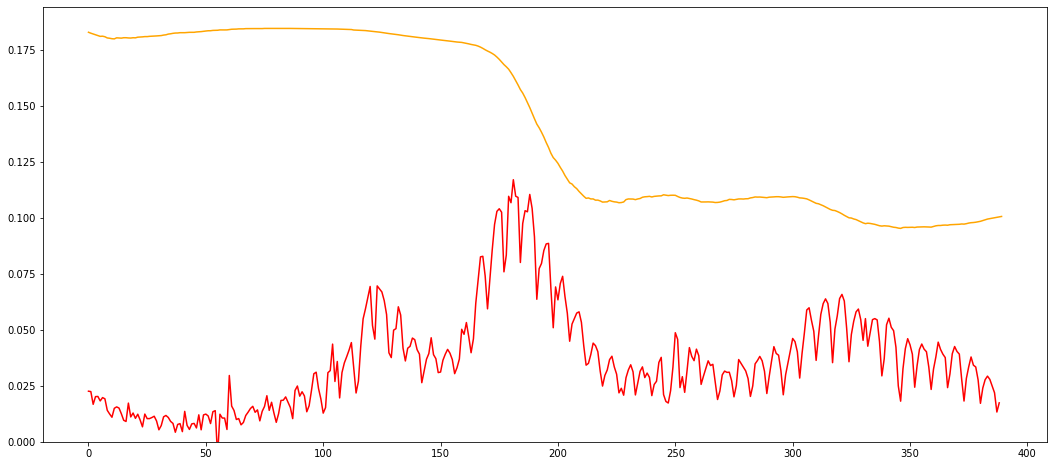

In [78]:
q = .09

paramMatrix = SIRD_Model.calculateAverageParams(infect, recov, dead, pop, q, graph=True, graphVals=[True,True,True,True])
betaTime = paramMatrix[:,0]

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.diff(infect+recov+dead), color='orange', label='new infect')


fig2, ax2 = plt.subplots(figsize=(18,8))
ax2.plot(beta, color='orange', label='Feedback Transmission Rate')
ax2.plot(betaTime, color='red')
ax2.set_ylim(0);